<a href="https://colab.research.google.com/github/kshwan95/Machine-Learning/blob/main/bike_sharing_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

본 대회는 Regression에 관련된 문제로, 도시 전역의 키오스크 위치 네트워크를 통해 멤버십, 렌탈 및 자전거 반품을 얻는 프로세스가 자동화되는 자전거를 임대하는 수단인 '자전거 공유 시스템'의 대여 정확한 수요 예측이 목표입니다.

**Data Fields**

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- 

```
# 코드로 형식 지정됨
```

count - number of total rentals

In [47]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

import missingno as msno
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [48]:
df_train = pd.read_csv("train.csv", parse_dates = ["datetime"])
df_test = pd.read_csv("test.csv", parse_dates = ["datetime"])

In [49]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [50]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [51]:
df_train.shape, df_test.shape

((10886, 12), (6493, 9))

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


* 결측치 확인

In [53]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)

column:   datetime	 Percent of NaN value: 0.00%
column:     season	 Percent of NaN value: 0.00%
column:    holiday	 Percent of NaN value: 0.00%
column: workingday	 Percent of NaN value: 0.00%
column:    weather	 Percent of NaN value: 0.00%
column:       temp	 Percent of NaN value: 0.00%
column:      atemp	 Percent of NaN value: 0.00%
column:   humidity	 Percent of NaN value: 0.00%
column:  windspeed	 Percent of NaN value: 0.00%
column:     casual	 Percent of NaN value: 0.00%
column: registered	 Percent of NaN value: 0.00%
column:      count	 Percent of NaN value: 0.00%


In [54]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column:   datetime	 Percent of NaN value: 0.00%
column:     season	 Percent of NaN value: 0.00%
column:    holiday	 Percent of NaN value: 0.00%
column: workingday	 Percent of NaN value: 0.00%
column:    weather	 Percent of NaN value: 0.00%
column:       temp	 Percent of NaN value: 0.00%
column:      atemp	 Percent of NaN value: 0.00%
column:   humidity	 Percent of NaN value: 0.00%
column:  windspeed	 Percent of NaN value: 0.00%


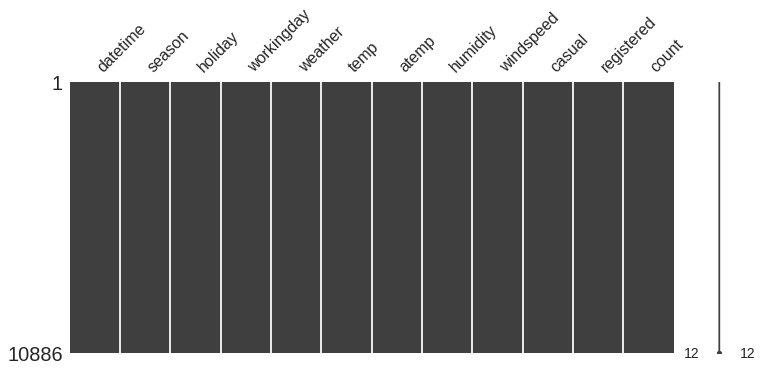

In [55]:
msno.matrix(df_train, figsize=(12,5))

* EDA

datetime의 데이터들을 편하게 알아보기위해 년,월,일,시,분,초 단위로 나눠준다.

확인결과 column이 18로 늘어난것을 볼 수 있다.

In [56]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second

df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour
df_test["minute"] = df_test["datetime"].dt.minute
df_test["second"] = df_test["datetime"].dt.second

df_train.shape

(10886, 18)

각 기준별 대여량을 직관적으로 살펴보기 위해 barplot을 사용하여 시각화 해줍니다.
연도별 대여량을 보면 11년도보다 12년도가 대여량이 늘어난것을 알 수 있습니다. 
월별 대여량을 보면 대체로 겨울보다 여름에 대여량이 높은것으로 보입니다.
일별 대여량은 1~19일까지의 데이터만 포함된다. 나머지는 test데이터에 있으며 일단 보류하도록 합니다.
시간별 대여량은 오전8시와 오후5시, 오후6시 가량이 높은데, 출퇴근시간에 이용하는 고객이 많아서 그런것으로 판단됩니다.

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

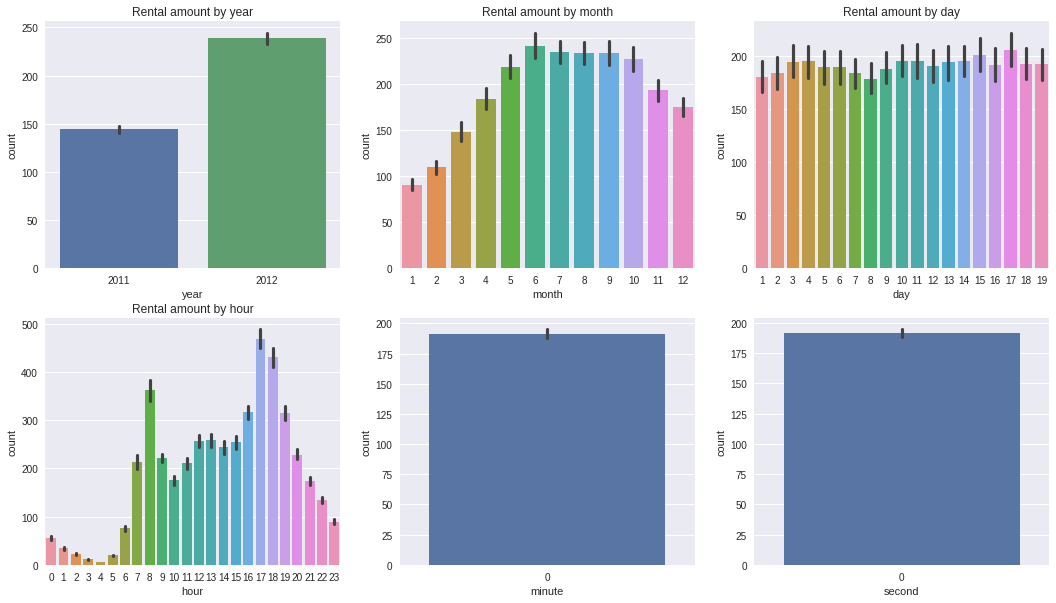

In [57]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(18,10)

sns.barplot(data=df_train, x = "year", y = "count", ax = ax1)
sns.barplot(data=df_train, x = "month", y = "count", ax = ax2)
sns.barplot(data=df_train, x = "day", y = "count", ax = ax3)
sns.barplot(data=df_train, x = "hour", y = "count", ax = ax4)
sns.barplot(data=df_train, x = "minute", y = "count", ax = ax5)
sns.barplot(data=df_train, x = "second", y = "count", ax = ax6)

ax1.set(ylabel = "count", title = "Rental amount by year")
ax2.set(ylabel = "count", title = "Rental amount by month")
ax3.set(ylabel = "count", title = "Rental amount by day")
ax4.set(ylabel = "count", title = "Rental amount by hour")

요일 변수를 추가로 생성해줍니다.

제대로 생성되어 column의 수가 19개로 늘어났습니다.

In [58]:
df_train["dayofweek"] = df_train["datetime"].dt.dayofweek
df_test["dayofweek"] = df_test["datetime"].dt.dayofweek
df_train.shape

(10886, 19)

0~6까지의 범주의 갯수를 세어줍니다. 
0 = 월요일 ~ 6 = 일요일입니다.
5,6(토, 일)의 대여량이 조금더 많은 것으로 보아 앞서 살펴본 workingday의 Boxplot 내용과 어느정도 일치하는 것으로 보입니다.

In [59]:
df_train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

시간의 흐름에 따른 pointplot을 그려줍니다.
첫번째 plot은 역시 앞서 보았던 결과들과 일치합니다.
두번째 plot을 보면 근무일때는 출퇴근시간에 집중되어 있지만, 아닌 경우는 그래프가 낮시간에 전체적으로 평이합니다. 
세번째 plot을 보면 역시 두번째 plot과 마찬가지로 토,일은 낮시간에 전체적으로 평이하고, 나머지 요일은 출퇴근 시간에 집중됩니다.
네번째 plot을 보면 맑은날이 역시 가장 높은 대여량을 보이고, 그 다음으로 안개, 가벼운 눈비가 오늘 날씨순으로 대여량이 많습니다. 악천후인 날씨는 없다고 봐도 무방할 정도입니다.
마지막 plot을 보면 봄이 가장적으며, 여름 가을 겨울은 조금의 차이가 나는 것으로 보입니다.

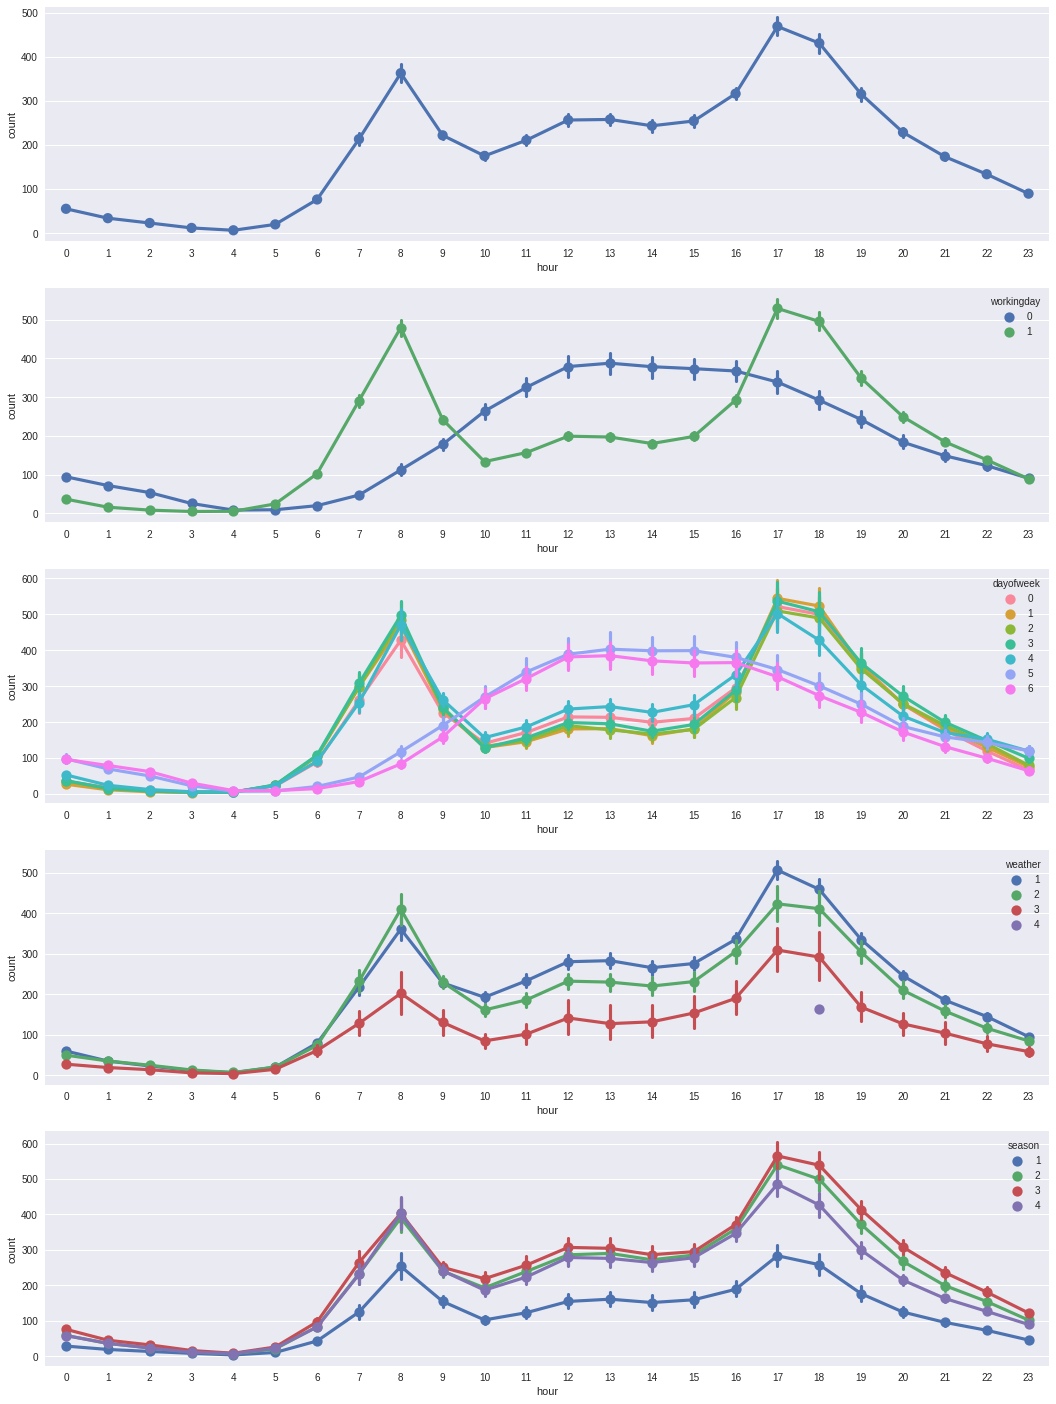

In [60]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(18,25)

sns.pointplot(data = df_train, x = "hour", y = "count", ax = ax1)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "weather", ax = ax4)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "season",  ax = ax5)

수치형 데이터들의 상관관계를 알아보기위해 Heatmap을 그려봅니다.
count의 열을 보면 가장 눈에 띄게 진한 변수는 registered입니다. 이 변수는 test데이터엔 존재하지 않습니다.
그 다음으로 상관계수가 높은 변수는 casual이다.
온도, 습도, 풍속은 거의 관계가 없다고 볼 수 있다.
temp와 atemp는 온도, 체감온도인데 상관계수가 매우 높은걸로 봐서 다중공선성을 보인다고 할 수 있다.

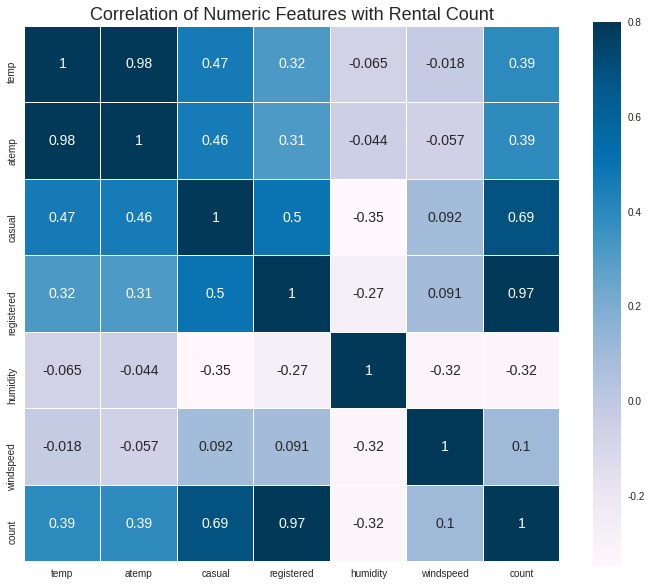

In [61]:
corr_data = df_train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]

colormap = plt.cm.PuBu
 
f , ax = plt.subplots(figsize = (12,10))
plt.title('Correlation of Numeric Features with Rental Count',y=1,size=18)
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap,
            linecolor="white",annot_kws = {'size':14})

유의하지 않다고 판단된 변수에 대해서 Scatterplot을 그려봅니다.
windspeed의 경우 0에 많은 데이터가 몰려있습니다. 
일반적으로 풍속이 0인 경우가 흔치 않으므로 Null데이터를 0으로 대체한게 아닌가 생각해볼 수 있습니다. 

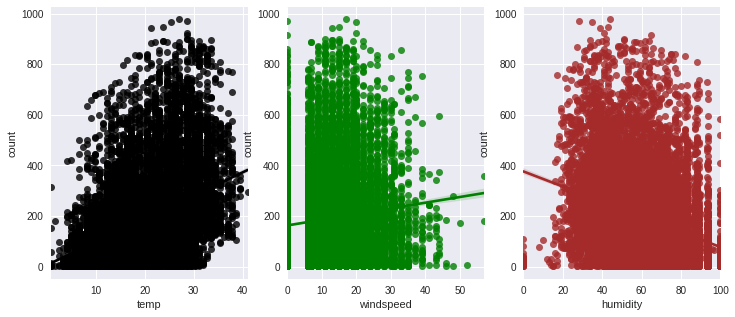

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

temp_scatter_plot = pd.concat([df_train['count'],df_train['temp']],axis = 1)
sns.regplot(x='temp',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1,color="black")
windspeed_scatter_plot = pd.concat([df_train['count'],df_train['windspeed']],axis = 1)
sns.regplot(x='windspeed',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2,color="green")
humidity_scatter_plot = pd.concat([df_train['count'],df_train['humidity']],axis = 1)
sns.regplot(x='humidity',y = 'count',data = humidity_scatter_plot,scatter= True, fit_reg=True, ax=ax3,color="brown")

풍속에 대한 자세한 시각화를 해준다.
0에대한 값이 매우많다.
Feature engineering에서 고쳐주도록 한다.

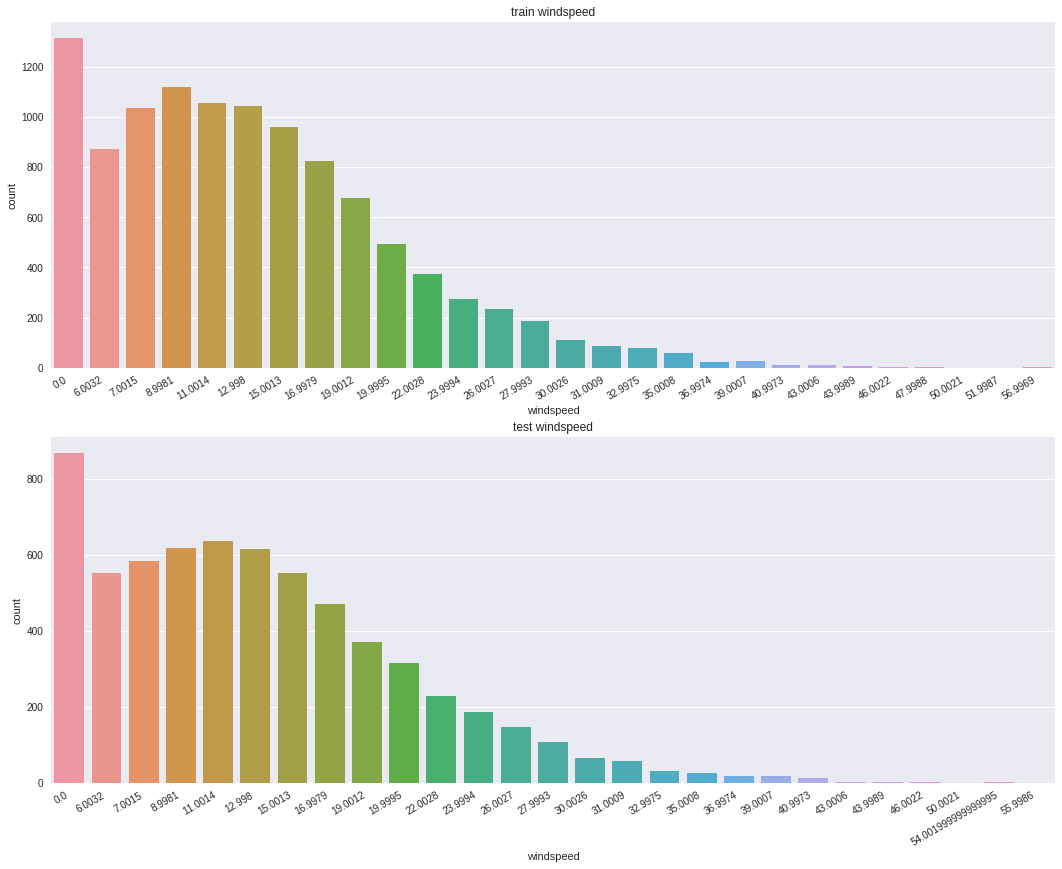

In [63]:
fig, axes = plt.subplots(nrows = 2, figsize = (18,14))

plt.sca(axes[0])
plt.xticks(rotation = 30, ha = "right")
axes[0].set(ylabel = "count", title = "train windspeed")
sns.countplot(data = df_train, x = "windspeed", ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30, ha = "right")
axes[1].set(ylabel = "count", title = "test windspeed")
sns.countplot(data = df_test, x = "windspeed", ax = axes[1])

연도별 데이터의 대여 변화를 좀더 자세히 보기위해 year와 month 데이터를 붙여줍니다.

In [64]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

df_train["year_month"] = df_train["datetime"].apply(concatenate_year_month)
df_test["year_month"] = df_test["datetime"].apply(concatenate_year_month) 
    
print(df_train.shape)
df_train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


2011년에 비해 2012년의 대여량이 높아졌던것을 확인했었는데, 두 년도를 월별로 시각화하여 좀 더 연속적으로 보도록합니다.
역시나 2012년의 대여량이 대체적으로 높으며, 두 연도 모두 따뜻한 계절의 대여량이 더 높습니다.
전체적으로 보면 갈수록 대여량이 증가하는 추세입니다.

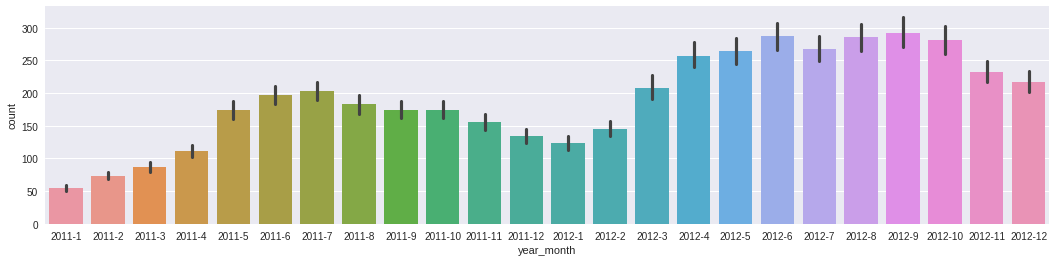

In [65]:
fig, ax = plt.subplots(figsize = (18,4))

sns.barplot(data = df_train, y = "count", x = "year_month")

train 데이터의 이상치를 탐색합니다.
IQR(튜키의 방법)을 이용한 함수를 지정하여 이상치 탐색을 수행합니다.

In [66]:
from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(df_train, 2, ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"])

In [67]:
df_train.loc[Outliers_to_drop]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year_month
6658,2012-03-14 17:00:00,1,0,1,1,28.70,31.820,28,6.0032,140,642,782,2012,3,14,17,0,0,2,2012-3
6779,2012-03-19 18:00:00,1,0,1,1,26.24,31.060,57,16.9979,120,681,801,2012,3,19,18,0,0,0,2012-3
6825,2012-04-02 17:00:00,2,0,1,1,20.50,24.240,29,19.0012,128,601,729,2012,4,2,17,0,0,0,2012-4
6849,2012-04-03 17:00:00,2,0,1,1,25.42,30.305,17,12.9980,123,634,757,2012,4,3,17,0,0,1,2012-4
6850,2012-04-03 18:00:00,2,0,1,1,24.60,30.305,26,11.0014,139,661,800,2012,4,3,18,0,0,1,2012-4
6897,2012-04-05 17:00:00,2,0,1,1,20.50,24.240,31,11.0014,145,677,822,2012,4,5,17,0,0,3,2012-4
7088,2012-04-13 17:00:00,2,0,1,1,22.96,26.515,24,11.0014,117,621,738,2012,4,13,17,0,0,4,2012-4
7640,2012-05-17 17:00:00,2,0,1,1,27.06,31.060,31,8.9981,133,719,852,2012,5,17,17,0,0,3,2012-5
7641,2012-05-17 18:00:00,2,0,1,1,27.06,31.060,27,11.0014,134,734,868,2012,5,17,18,0,0,3,2012-5
7664,2012-05-18 17:00:00,2,0,1,1,27.06,31.060,34,8.9981,124,688,812,2012,5,18,17,0,0,4,2012-5


In [68]:
df_train = df_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df_train.shape

(10846, 20)

Data의 분포 모양이 이러한 정규 분포에서 어느 정도 벗어나 있는지 살펴보기 위한 지표로 첨도 왜도 확인

In [69]:
df_train_num = df_train[["count", "temp", "atemp", "casual", "registered", "humidity", "windspeed"]]

for col in df_train_num:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

count           Skewness: 01.21     Kurtosis: 001.20
temp            Skewness: 00.01     Kurtosis: -00.91
atemp           Skewness: -0.10     Kurtosis: -00.85
casual          Skewness: 02.52     Kurtosis: 007.74
registered      Skewness: 01.51     Kurtosis: 002.61
humidity        Skewness: -0.09     Kurtosis: -00.76
windspeed       Skewness: 00.58     Kurtosis: 000.63


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental count by minute')]

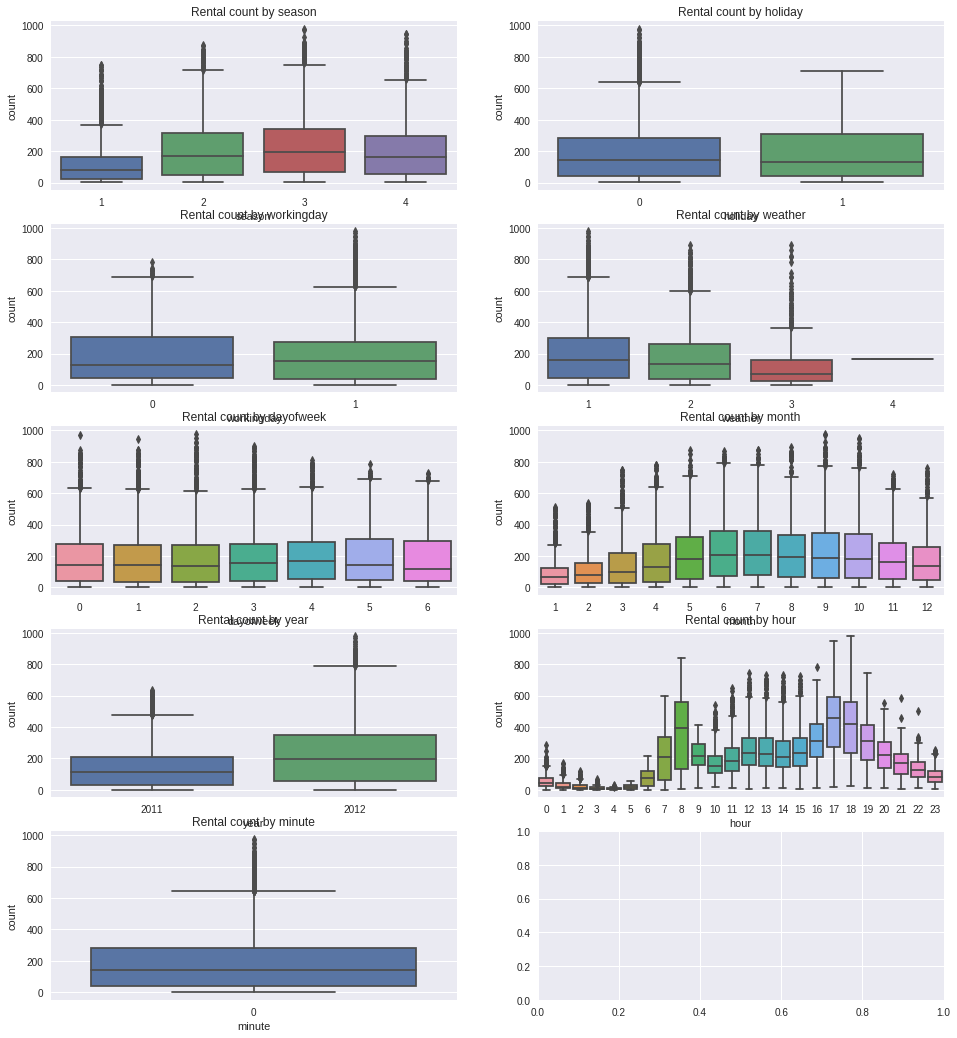

In [70]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(16, 18))
sns.boxplot(data = df_train, y="count", x = "season", orient = "v", ax = axes[0][0])
sns.boxplot(data = df_train, y="count", x = "holiday", orient = "v", ax = axes[0][1])
sns.boxplot(data = df_train, y="count", x = "workingday", orient = "v", ax = axes[1][0])
sns.boxplot(data = df_train, y="count", x = "weather", orient = "v", ax = axes[1][1])
sns.boxplot(data = df_train, y="count", x = "dayofweek", orient = "v", ax = axes[2][0])
sns.boxplot(data = df_train, y="count", x = "month", orient = "v", ax = axes[2][1])
sns.boxplot(data = df_train, y="count", x = "year", orient = "v", ax = axes[3][0])
sns.boxplot(data = df_train, y="count", x = "hour", orient = "v", ax = axes[3][1])
sns.boxplot(data = df_train, y="count", x = "minute", orient = "v", ax = axes[4][0])

axes[0][0].set(ylabel = "count", title = "Rental count by season")
axes[0][1].set(ylabel = "count", title = "Rental count by holiday")
axes[1][0].set(ylabel = "count", title = "Rental count by workingday")
axes[1][1].set(ylabel = "count", title = "Rental count by weather")
axes[2][0].set(ylabel = "count", title = "Rental count by dayofweek")
axes[2][1].set(ylabel = "count", title = "Rental count by month")
axes[3][0].set(ylabel = "count", title = "Rental count by year")
axes[3][1].set(ylabel = "count", title = "Rental count by hour")
axes[4][0].set(ylabel = "count", title = "Rental count by minute")

Feature Engineering

첨도와 왜도 확인

Skewness: 1.210923
Kurtosis: 1.200871


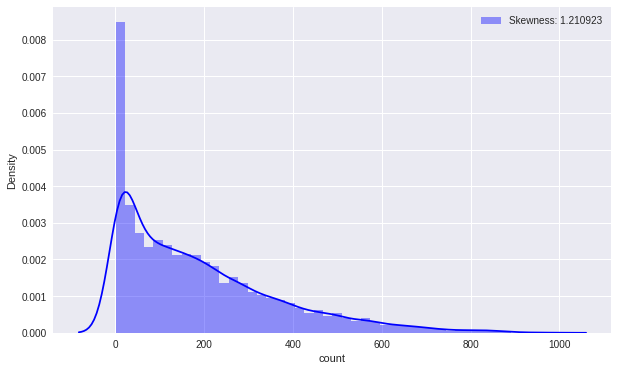

In [71]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train["count"].skew())
print("Kurtosis: %f" % df_train["count"].kurt())

치우침 해소를위해 로그를 취한다

Skewness: -0.975198
Kurtosis: 0.247435


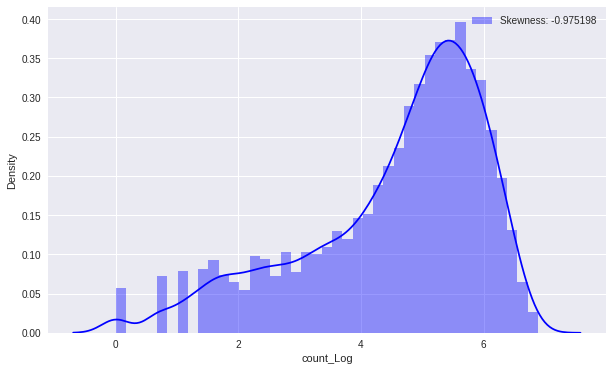

In [72]:
df_train["count_Log"] = df_train["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count_Log"], color = "b", label="Skewness: {:2f}".format(df_train["count_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train['count_Log'].skew())
print("Kurtosis: %f" % df_train['count_Log'].kurt())

df_train.drop('count', axis= 1, inplace=True)

풍속 변수의 0값 데이터들을 만져주기 위해 0인 값과 아닌 값들로 나눠줍니다.

In [73]:
trainWind0 = df_train.loc[df_train["windspeed"] == 0]
trainWindNot0 = df_train.loc[df_train["windspeed"] != 0]

In [74]:
from sklearn.ensemble import RandomForestClassifier
# RandomForest로 값을 예측해보도록 합니다.
def predict_windspeed(data):
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]
    # 풍속 데이터를 0인 값과 아닌 값들로 나눠줍니다.
    wcol = ["season", "weather", "humidity", "day", "temp", "atemp"]
    # 예측에 필요한 변수들을 지정합니다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    # 풍속이 0이 아닌 값들을 string데이터로 변환합니다.
    rf_wind = RandomForestClassifier()
    rf_wind.fit(dataWindNot0[wcol], dataWindNot0["windspeed"])
    wind0 = rf_wind.predict(X=dataWind0[wcol])
    # 랜덤포레스트를 사용하여 wcol의 변수들로 0인 값들을 학습시키고 예측합니다.
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    # 예측한 값을 넣어줄 데이터프레임을 만듭니다.
    predictWind0["windspeed"] = wind0
    # 예측값들을 넣어줍니다.
    data = predictWindNot0.append(predictWind0)
    # 0이 아닌 데이터들과 예측값들을 합쳐줍니다.
    data["windspeed"] = data["windspeed"].astype("float")
    # 풍속의 데이터들을 다시 float 타입으로 변환합니다.
    data.reset_index(inplace = True)
    data.drop("index", inplace = True, axis = 1)
    
    return data

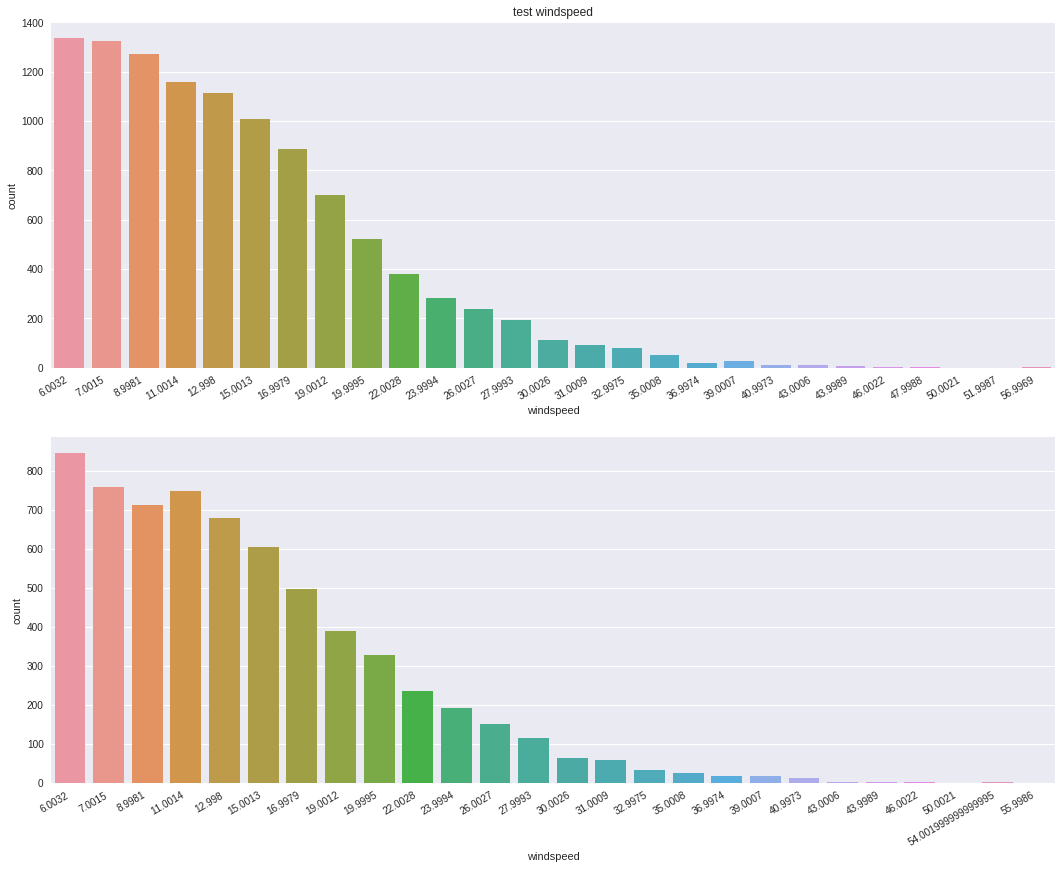

In [75]:
df_train = predict_windspeed(df_train)
df_test = predict_windspeed(df_test)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (18,14))

plt.sca(ax1)
plt.xticks(rotation = 30, ha = "right")
ax1.set(ylabel = "count", title = "train windspeed")
sns.countplot(data = df_train, x = "windspeed", ax = ax1)

plt.sca(ax2)
plt.xticks(rotation = 30, ha = "right")
ax1.set(ylabel = "count", title = "test windspeed")
sns.countplot(data = df_test, x = "windspeed", ax = ax2)

In [76]:
df_train = pd.get_dummies(df_train, columns = ["weather"], prefix = "weather")
df_test = pd.get_dummies(df_test, columns = ["weather"], prefix = "weather")

df_train = pd.get_dummies(df_train, columns = ["season"], prefix = "season")
df_test = pd.get_dummies(df_test, columns = ["season"], prefix = "season")

#onehotencoding

In [77]:
corr_data = df_train[["count_Log", "windspeed"]]
corr_data.corr()

,count_Log,windspeed
count_Log,1.000000,0.125319
windspeed,0.125319,1.000000


In [78]:
datetime_test = df_test['datetime']

df_train.drop(["datetime", "registered","casual","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)
df_test.drop(["datetime","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)

In [79]:
df_train.head()

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,count_Log,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,0,9.84,12.880,75,6.0032,2011,1,1,5,5,0.000000,0,1,0,0,1,0,0,0
1,0,15.58,19.695,76,16.9979,2011,1,1,10,5,3.583519,1,0,0,0,1,0,0,0
2,0,14.76,16.665,81,19.0012,2011,1,1,11,5,4.025352,1,0,0,0,1,0,0,0
3,0,17.22,21.210,77,19.0012,2011,1,1,12,5,4.430817,1,0,0,0,1,0,0,0
4,0,18.86,22.725,72,19.9995,2011,1,1,13,5,4.543295,0,1,0,0,1,0,0,0


In [80]:
df_test.head(20)

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,1,10.66,11.365,56,26.0027,2011,1,20,0,3,1,0,0,0,1,0,0,0
1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,1,0,0,0,1,0,0,0
2,1,10.66,12.880,56,11.0014,2011,1,20,4,3,1,0,0,0,1,0,0,0
3,1,9.84,11.365,60,15.0013,2011,1,20,5,3,1,0,0,0,1,0,0,0
4,1,9.02,10.605,60,15.0013,2011,1,20,6,3,1,0,0,0,1,0,0,0
5,1,9.02,10.605,55,15.0013,2011,1,20,7,3,1,0,0,0,1,0,0,0
6,1,9.02,10.605,55,19.0012,2011,1,20,8,3,1,0,0,0,1,0,0,0
7,1,9.84,11.365,52,15.0013,2011,1,20,9,3,0,1,0,0,1,0,0,0
8,1,10.66,11.365,48,19.9995,2011,1,20,10,3,1,0,0,0,1,0,0,0
9,1,11.48,13.635,45,11.0014,2011,1,20,11,3,0,1,0,0,1,0,0,0


Model & Make Submission

In [81]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
X_train = df_train.drop("count_Log", axis = 1).values 
target_label = df_train["count_Log"].values 
X_test = df_test.values 
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

Gradient Boost


*   여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
*   회귀와 분류에 모두 사용할 수 있음
*   랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
*   무작위성이 없고 강력한 사전 가지치기가 사용됨
*   1~5개의 깊지 않는 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
*   Learning_rate: 오차를 얼마나 강하게 보정할 것인지 제어
*   n_estimatort의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅이 될 수 있다
*   max_depth복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다









In [82]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, 
                                   min_samples_leaf=15, min_samples_split=10, random_state =42) 

regressor.fit(X_tr,y_tr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

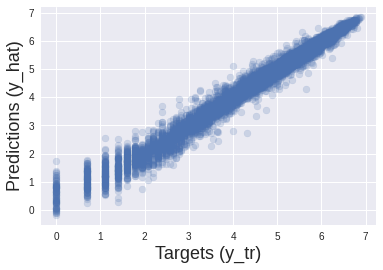

In [83]:
y_hat = regressor.predict(X_tr)
plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

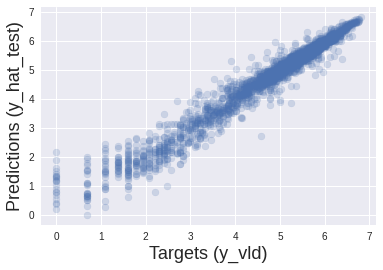

In [84]:
y_hat_test = regressor.predict(X_vld)
plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_vld)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

In [85]:
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

models=[GradientBoostingRegressor()]
model_names=['regressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_tr,y_tr)
    test_pred=clf.predict(X_vld)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_vld)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['regressor'], 'RMSLE': [0.12983740009841266]}

In [86]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 8)

In [87]:
print(accuracies.mean()) 
print(accuracies.std())

0.9564875403985083
0.0037457806807483416


In [88]:
use_logvals = 1 

pred_xgb = regressor.predict(X_test) 

sub_xgb = pd.DataFrame() 
sub_xgb['datetime'] = datetime_test 
sub_xgb['count'] = pred_xgb 
if use_logvals == 1:
    sub_xgb['count'] = np.exp(sub_xgb['count'])
    
sub_xgb.to_csv('xgb.csv',index=False)